In [1]:
from model import *
from plot_functions import * 
import itertools

%matplotlib inline
%config InlineBackend.figure_format = 'svg' ## 'svg'

%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
import pandas as pd

In [2]:
# simulations_ON_rE = 'C:\\Users\\David\\Desktop\\IDIBAPS\\simulations_christos\\simuls_on_class_re.xlsx'
# simulations_ON_targets = 'C:\\Users\\David\\Desktop\\IDIBAPS\\simulations_christos\\simuls_on_class_targets.xlsx'

# simulations_OFF_rE = 'C:\\Users\\David\\Desktop\\IDIBAPS\\simulations_christos\\simuls_off_class_re.xlsx'
# simulations_OFF_targets = 'C:\\Users\\David\\Desktop\\IDIBAPS\\simulations_christos\\simuls_off_class_targets.xlsx'

# y_off_all=pd.read_excel(simulations_OFF_targets).values
# X_off_all= pd.read_excel(simulations_OFF_rE).values

# y_on_all=pd.read_excel(simulations_ON_targets).values
# X_on_all= pd.read_excel(simulations_ON_rE).values

In [3]:
##guardar los datos de la neurona 0, 1, y 256 
# simpl_X_on_all= pd.DataFrame(X_on_all[:, 0])
# simpl_X_on_all.to_excel('C:\\Users\\David\\Desktop\\IDIBAPS\\simulations_christos\\neuron0_simuls_on_class_re.xlsx')
# simpl_X_off_all= pd.DataFrame(X_off_all[:, 0])
# simpl_X_off_all.to_excel('C:\\Users\\David\\Desktop\\IDIBAPS\\simulations_christos\\neuron0_simuls_off_class_re.xlsx')


# simpl_X_on_all= pd.DataFrame(X_on_all[:, 1])
# simpl_X_on_all.to_excel('C:\\Users\\David\\Desktop\\IDIBAPS\\simulations_christos\\neuron1_simuls_on_class_re.xlsx')
# simpl_X_off_all= pd.DataFrame(X_off_all[:, 1])
# simpl_X_off_all.to_excel('C:\\Users\\David\\Desktop\\IDIBAPS\\simulations_christos\\neuron1_simuls_off_class_re.xlsx')


# simpl_X_on_all= pd.DataFrame(X_on_all[:, int(512/2)])
# simpl_X_on_all.to_excel('C:\\Users\\David\\Desktop\\IDIBAPS\\simulations_christos\\neuron256_simuls_on_class_re.xlsx')
# simpl_X_off_all= pd.DataFrame(X_off_all[:, int(512/2)])
# simpl_X_off_all.to_excel('C:\\Users\\David\\Desktop\\IDIBAPS\\simulations_christos\\neuron256_simuls_off_class_re.xlsx')

In [4]:
simpl_X_on_all = pd.read_excel('results/neuron256_simuls_on_class_re.xlsx')
simpl_X_off_all = pd.read_excel('results/neuron256_simuls_off_class_re.xlsx')


simulations_ON_targets = 'results/simuls_on_class_targets.xlsx'
simulations_OFF_targets = 'results/simuls_off_class_targets.xlsx'

y_off_all=pd.read_excel(simulations_OFF_targets).values
y_on_all=pd.read_excel(simulations_ON_targets).values


In [5]:
### Sampleo cada 3 grados
### La proporción de 1 vs 0 es de 0.06 (seis 1 y 94 0)
### Dentro del window +-10º hay 7 puntos de 1 (171, 174, 177, 180, 183, 186, 189 ) (7/120)
### test size del 30% para asegurar buen training en la mayoría

### Los errores se producen en los datos cercanos al target window (que cuentan como 0 pero en ON se parecen más a 1 (10º))

In [6]:
y_off=y_off_all.copy()
X_off=simpl_X_off_all.copy()

y_on=y_on_all.copy()
X_on=simpl_X_on_all.copy()

In [7]:
Window = 360 ###20
n_neuron=180 
inic=n_neuron - int(Window/2)
fin=n_neuron + int(Window/2)
lim_inf = 170
lim_sup = 190
sampling_ = 3
##wind=100
reps_=25


uniques_ = np.unique(y_off[::sampling_])


## get y_off
bool_int = np.array([y_off[x] in uniques_ for x in range(len(y_off))])
y_off = y_off[bool_int]
y_off_tar = np.reshape(y_off, (len(y_off),1))


boo=[]
for i in range(len(y_off_tar)):
    if y_off_tar[i]<lim_inf:
        boo.append(0)
    elif y_off_tar[i]>lim_sup:
        boo.append(0)
    else:
        boo.append(1)


y_off_t = np.array(boo)    
y_off= label_binarize(y_off_t, classes=[0,1]) #matrix (1,0,0,...,0)


n_classes = y_off.shape[1]


## get X_off
bool_reshaped = np.reshape(bool_int, (len(bool_int)))
X_off = X_off[bool_reshaped]
X_off =np.reshape(X_off, (len(X_off),1))

########################################################################

## get y_on
bool_int =  np.array([y_on[x] in uniques_ for x in range(len(y_on))])
y_on = y_on[bool_int]
y_on_tar = np.reshape(y_on, (len(y_on),1))


boo=[]
for i in range(len(y_on_tar)):
    if y_on_tar[i]<lim_inf:
        boo.append(0)
    elif y_on_tar[i]>lim_sup:
        boo.append(0)
    else:
        boo.append(1)


y_on_t = np.array(boo)    
y_on= label_binarize(y_on_t, classes=[0,1]) #matrix (1,0,0,...,0)


n_classes = y_on.shape[1]

## get X_off
bool_reshaped = np.reshape(bool_int, (len(bool_int)))
X_on = X_on[bool_reshaped]
X_on =np.reshape(X_on, (len(X_on),1))


##classifier to use
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True, random_state=None, max_iter=10000)) #, max_iter=10000

fpr_mean_off = []
tpr_mean_off = []
roc_mean_off = []

fpr_mean_on = []
tpr_mean_on = []
roc_mean_on = []



for stimulation in ['ON', 'OFF']:
    if stimulation=='ON':
        X=X_on
        y=y_on
    elif stimulation=='OFF':
        X=X_off
        y=y_off
    
    ###
    ### many train and test to validate the measure
    for rep in range(reps_):
        print(stimulation, rep)
        ## split train and test
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=None)
        X_train =np.reshape(X_train, (len(X_train),1))
        X_test =np.reshape(X_test, (len(X_test),1))
        # score
        #fitted = classifier.fit(X_train, y_train)
        #y_score = fitted.decision_function(X_test)
        
        #X_test = X_test[y_test[:, int(Window/2) ]==1]
        #y_test = y_test[y_test[:, int(Window/2)]==1]
        
        #bool_ = np.array([any(y_test[x ,int(Window/2)-int(Window2/2): int(Window/2)+int(Window2/2)])==1 for x in range(len(y_test))])
        #X_test = X_test[bool_]
        #y_test = y_test[bool_]
        #n_classes = y_test.shape[1]
        
        
        y_score = classifier.fit(X_train, y_train).decision_function(X_test)

        ## Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr= dict()
        roc_auc = dict()
        for i in range(n_classes):
            #fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
            fpr[i], tpr[i], _ = roc_curve(y_test[:], y_score[:])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        ### Compute mean ROC curve

        # First aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += interp(all_fpr, fpr[i], tpr[i])

        # Finally average it and compute AUC
        mean_tpr /= n_classes

        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
        #
        if stimulation=='ON':
            fpr_mean_on.append(fpr["macro"])
            tpr_mean_on.append(tpr["macro"])
            roc_mean_on.append(roc_auc["macro"])
        elif stimulation=='OFF':
            fpr_mean_off.append(fpr["macro"])
            tpr_mean_off.append(tpr["macro"])
            roc_mean_off.append(roc_auc["macro"])


    
####

ON 0
ON 1
ON 2
ON 3
ON 4
ON 5
ON 6
ON 7
ON 8
ON 9
ON 10
ON 11
ON 12
ON 13
ON 14
ON 15
ON 16
ON 17
ON 18
ON 19
ON 20
ON 21
ON 22
ON 23
ON 24
OFF 0
OFF 1
OFF 2
OFF 3
OFF 4
OFF 5
OFF 6
OFF 7
OFF 8
OFF 9
OFF 10
OFF 11
OFF 12
OFF 13
OFF 14
OFF 15
OFF 16
OFF 17
OFF 18
OFF 19
OFF 20
OFF 21
OFF 22
OFF 23
OFF 24


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


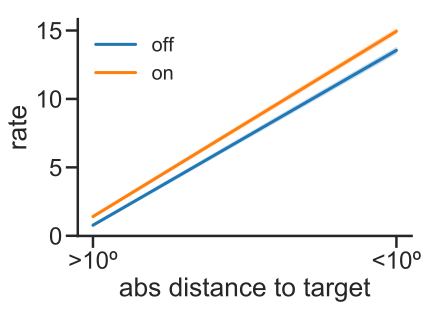

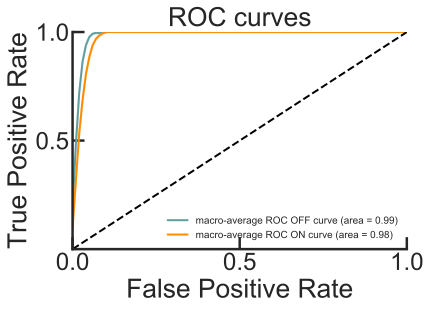

Ttest_indResult(statistic=-16.509924202533067, pvalue=1.9959786051136425e-21)

In [8]:
plt.figure()
off = pd.DataFrame({'rate':X_off[0].values, 'target':pd.DataFrame(y_off_t)[0].values})
on = pd.DataFrame({'rate':X_on[0].values, 'target':pd.DataFrame(y_on_t)[0].values})
sns.lineplot(x='target', y='rate', data=off, label='off')
sns.lineplot(x='target', y='rate', data=on, label='on')
plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
plt.gca().spines['top'].set_visible(False)                                                                                  # remove top spines
plt.gca().get_xaxis().tick_bottom()                                                                                         
plt.gca().get_yaxis().tick_left()
plt.xticks([0,1], ['>10º', '<10º'])
plt.xlabel('abs distance to target')
plt.legend(fontsize=20, frameon=False)
plt.show()


plt.figure()
lw = 2

fpr_mean_off = np.concatenate(fpr_mean_off)
tpr_mean_off = np.concatenate(tpr_mean_off)
df_ROC_OFF = pd.DataFrame({'fpr_mean': fpr_mean_off, 'tpr_mean': tpr_mean_off})
df_ROC_OFF = df_ROC_OFF.round(2)


sns.lineplot(x='fpr_mean', y='tpr_mean', data=df_ROC_OFF, color='cadetblue', 
             linestyle='--', linewidth=2, 
             label='macro-average ROC OFF curve (area = {0:0.2f})'''.format(np.mean(roc_mean_off)))



fpr_mean_on = np.concatenate(fpr_mean_on)
tpr_mean_on = np.concatenate(tpr_mean_on)
df_ROC_ON = pd.DataFrame({'fpr_mean': fpr_mean_on, 'tpr_mean': tpr_mean_on})
df_ROC_ON = df_ROC_ON.round(2)


sns.lineplot(x='fpr_mean', y='tpr_mean', data=df_ROC_ON, color='darkorange', 
             linestyle='--', linewidth=2, 
             label='macro-average ROC ON curve (area = {0:0.2f})'''.format(np.mean(roc_mean_on)))


###
plt.plot([0, 1], [0, 1], color='k', lw=lw, linestyle='--')
plt.xlim([0, 1])
plt.xticks([0, 0.5, 1])
plt.ylim([0, 1])
plt.yticks([0.5, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves')
plt.legend(loc="lower right", fontsize=10, frameon=False)
plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
plt.gca().spines['top'].set_visible(False)                                                                                  # remove top spines
plt.gca().get_xaxis().tick_bottom()                                                                                         
plt.gca().get_yaxis().tick_left()
plt.gca().tick_params(direction='in') #direction
plt.show()
print('')
print('')

scipy.stats.ttest_ind(roc_mean_on, roc_mean_off)